## **TP2: Métodos** 

In [1]:
import numpy as np
import matplotlib as plt
import numpy.linalg as lng
from scipy.linalg import lu
from scipy import linalg
import networkx as nx
from scipy.stats.stats import pearsonr
import pandas as pd
import metnum as mt
import matplotlib.pyplot as plt
import seaborn as sns
import import_ipynb
import utils 
sns.set_style("whitegrid")

/tmp/ipykernel_125023/794504982.py:7: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


importing Jupyter notebook from utils.ipynb


# Club de Karate

Leer karate club con NetworkX

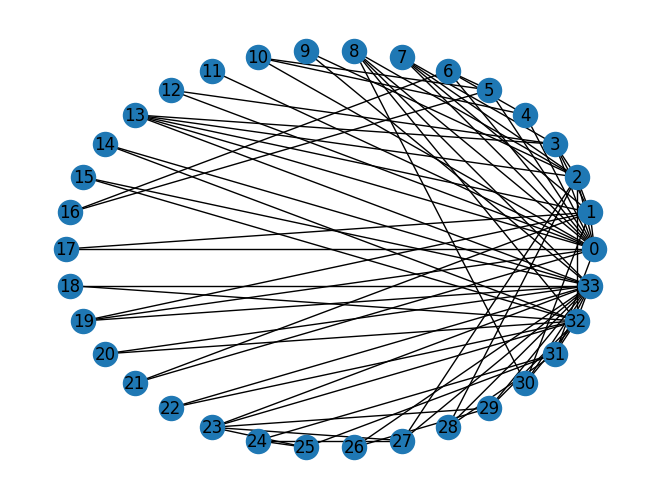

In [2]:
karate = nx.karate_club_graph()
nx.draw_circular(karate, with_labels = True)

Cargamos el grafo del club de karate

In [3]:
A = utils.leer_karateclub()
A_labels = utils.leer_labels_karate()

### Centralidad del autovector 

In [4]:
eigval, eigvect = mt.power_iteration(A.astype(float), 10000, 1e-10)

Matriz Laplaciana

In [5]:
L = np.zeros(34*34).reshape(34, 34)
np.fill_diagonal(L, np.sum(A, axis = 1))
L = L-A

Autovalores y Autovalores Laplaciana

In [6]:
L_eigval, L_eigvect = mt.deflation(L, 34, 10000, 1e-10)
#L_eigval, L_eigvect = np.linalg.eig(L)

#sort 
sort_labels_eigval = np.argsort(L_eigval)
L_eigval = L_eigval[sort_labels_eigval]
L_eigvect = L_eigvect[::, sort_labels_eigval]

Calculo de Correlación entre el vector resultado de cortar la red de karate con los autovectores vs el corte real 

max correlación 0.814734156427519
Autovector de mayor corelación 1


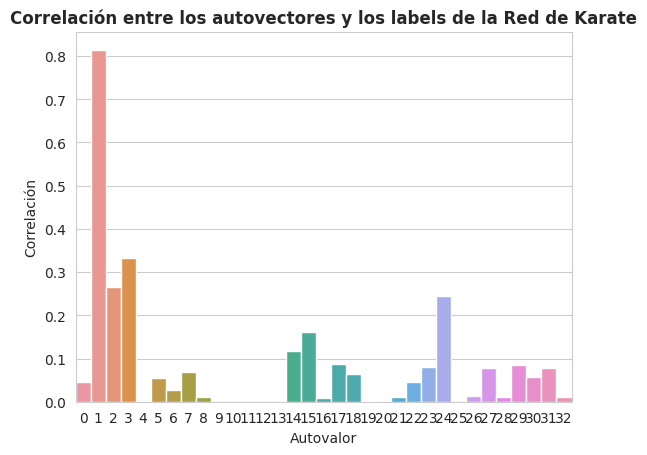

In [7]:

A_labels = utils.leer_labels_karate()

C = np.hstack([L_eigvect, A_labels.reshape(34,1)])

#correlation matrix 
C = abs(np.corrcoef(C.T))

corr = C[:, 34]
corr[34] = 0
corr = corr[0:33]
print("max correlación", max(corr))
print("Autovector de mayor corelación", corr.argmax())
corr_data = pd.DataFrame()
corr_data["Autovalor"] = list(range(0,33))
corr_data["Correlación"] = corr
display()
sns.barplot(corr_data, x = "Autovalor", y = "Correlación", width= 1)
plt.title("Correlación entre los autovectores y los labels de la Red de Karate", fontweight = "bold")
plt.show()

Que el autovector con mayor correlación al corte es el que está en la posición 1 corresponde con lo que preveiamos

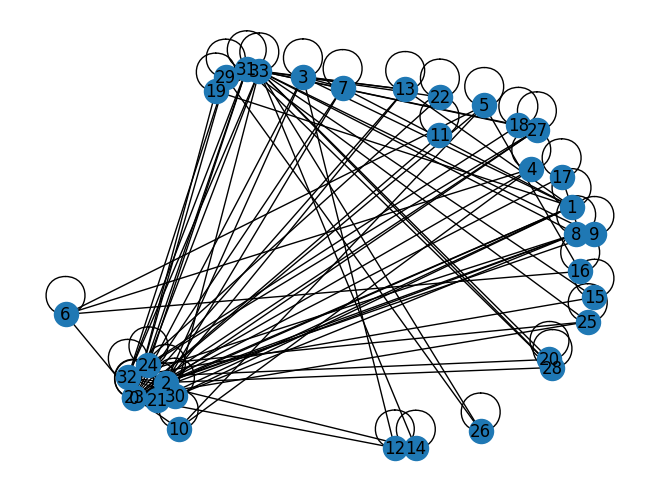

In [8]:
L_g = nx.from_numpy_array(L)
nx.draw_spring(L_g,  with_labels = True)

# FACEBOOK

Cargamos el feat y la matriz de adj de facebook

In [9]:
F_att, face = utils.leer_facebook()

,a,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
0,2661,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2662,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2663,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2664,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2665,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,3432,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
788,3433,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
789,3434,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
790,3435,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Matriz de Similaridad de facebook

In [10]:
mat_similaridad = F_att @ F_att.T

Todos los posibles umbrales

In [11]:
mat_similaridad_valores = np.unique(mat_similaridad.flatten())
print(mat_similaridad_valores)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


Analizamos la distribución de los valores en la matriz de similaridad con un histograma

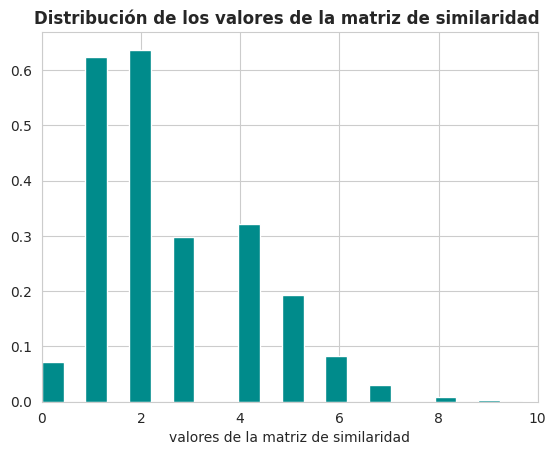

In [12]:
mat_simi_flatten = mat_similaridad.flatten()
plt.hist(mat_simi_flatten, 50, density= True, color = "darkcyan")
plt.title("Distribución de los valores de la matriz de similaridad ", fontweight="bold")
plt.xlim(0, 10)
plt.xlabel("valores de la matriz de similaridad")
plt.show()

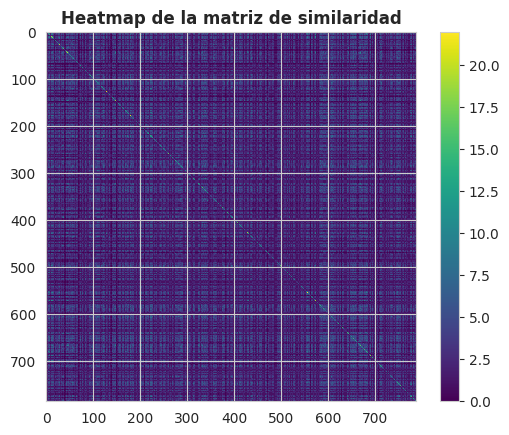

In [13]:
plt.imshow(mat_similaridad, interpolation= "nearest",  cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Heatmap de la matriz de similaridad", fontweight = "bold")
plt.show()

Vemos los valores correlación entre la matriz de atributos flatten y la matriz de similaridad filtrada flatten para todos los umbrales posibles

In [14]:
mat_similaridad_valores = np.unique(mat_similaridad.flatten())
face_mat_adj = face.flatten()
cor_flatten = []
for i in range(0, 21):
    mat_similaridad_index = mat_similaridad > i
    mat_similaridad_index = mat_similaridad_index.astype(int)
    mat_simi_filt = mat_similaridad_index.flatten()
    cor_flatten.append(np.corrcoef(mat_simi_filt,  face_mat_adj)[0,1])
cor_flatten = [abs(i) for i in cor_flatten]
print("max correlación", max(cor_flatten))

max correlación 0.10804842659646784


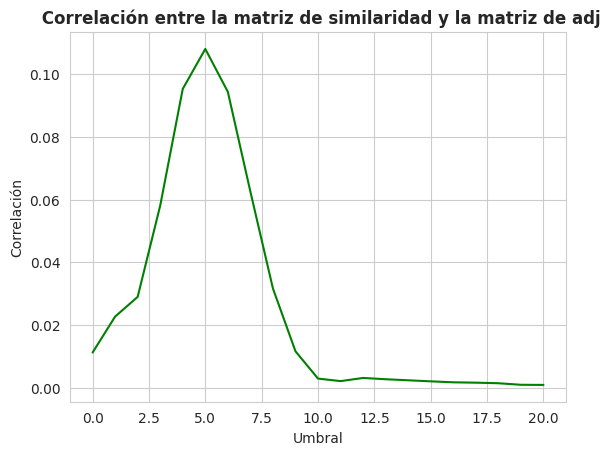

In [15]:
plt.plot(cor_flatten, color = "green")
plt.title(" Correlación entre la matriz de similaridad y la matriz de adj",  fontweight="bold")
plt.xlabel("Umbral")
plt.ylabel("Correlación")
plt.show()

Ahora vemos la correlación entre los autovalores de la matriz de similaridad y los autovalores de facebook 

In [16]:
mat_similaridad_valores = np.unique(mat_similaridad.flatten())
face_mat_adj = face
#print(np.allclose(face_mat_adj, face_mat_adj.T))
eigvals_face = sorted(linalg.eigvals(face_mat_adj))

cor_autoval = []
for i in range(0, 21):
    mat_similaridad_index = mat_similaridad > i
    mat_similaridad_index = mat_similaridad_index.astype(int)
    
    eigvals_simi = linalg.eigvals( mat_similaridad_index)
    eigvals_simi = sorted(eigvals_simi)
    
    cor_autoval.append(np.corrcoef(np.real(eigvals_simi), np.real(eigvals_face) )[0,1])
print("max correlación", max(cor_autoval))


max correlación 0.9595908617203155


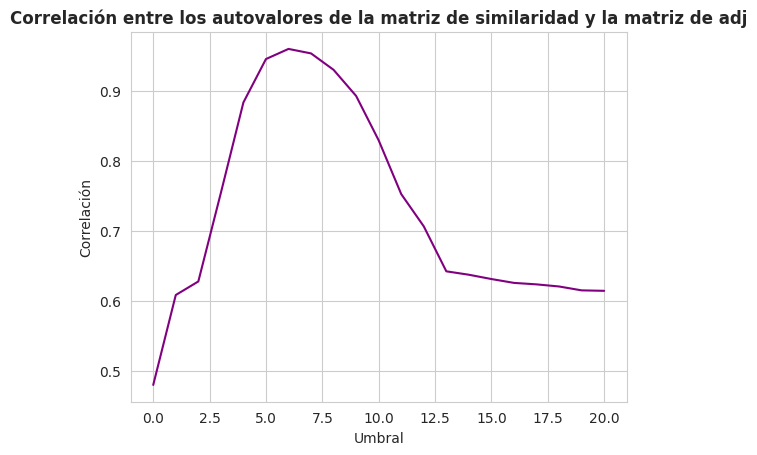

In [17]:
plt.plot(cor_autoval, color = "purple")
plt.title("Correlación entre los autovalores de la matriz de similaridad y la matriz de adj", fontweight="bold")
plt.xlabel("Umbral")
plt.ylabel("Correlación")
plt.show()

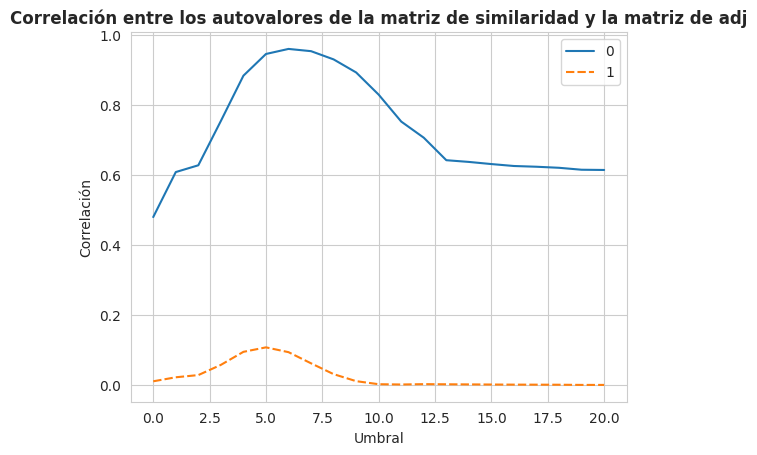

In [18]:
#Este no me gusta pq las escalas son muy distintas 
sns.lineplot([cor_autoval, cor_flatten])
plt.title("Correlación entre los autovalores de la matriz de similaridad y la matriz de adj", fontweight="bold")
plt.xlabel("Umbral")
plt.ylabel("Correlación")
plt.show()

# PCA 

### Matriz de covarianza 

In [19]:
#Creo que lo del mean anda bien 
m, n = F_att.shape 

X = F_att - F_att.mean(0)
print("dim mat de cov: ", X.shape)
Cov = X.T @ X / m



dim mat de cov:  (786, 319)


Calculo de autovectores y autovalores de la matriz de covarianza

In [20]:
#C_eigval, C_eigvect = mt.deflation(Cov, 34, 10000, 1e-10)
C_eigval, C_eigvect = np.linalg.eig(Cov)
C_eigval = np.real(C_eigval)
C_eigvect = np.real(C_eigvect)
#sort 
sort_labels_eigval = np.argsort(C_eigval)
C_eigval = C_eigval[sort_labels_eigval]
C_eigvect = C_eigvect[::, sort_labels_eigval]


Armamos V y D 

In [21]:
V = C_eigvect
D = np.zeros(786*319).reshape(786,319)
np.fill_diagonal(D, C_eigval)
print("dim D: " , D.shape)
print("dim V: ", V.shape)

dim D:  (786, 319)
dim V:  (319, 319)


Ahora tomo k = 100 y veo las componentes principales 
$ V_k \in \real^{319 \times 50} F\_att \in \real^{786 \times 50}$ 

(100, 319)
(786, 319)


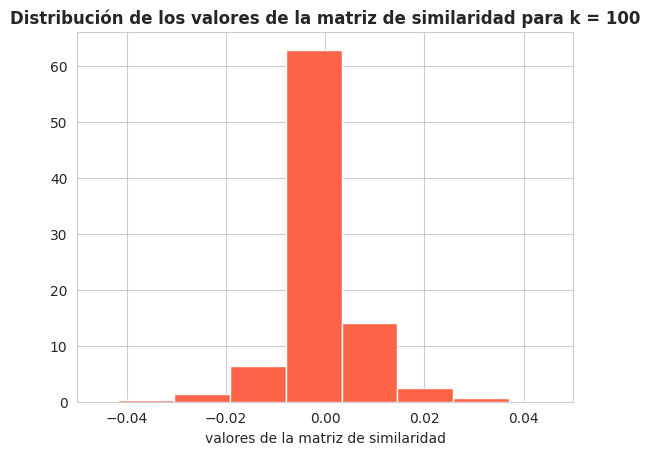

In [22]:
k = 100
V_k = V[: , 0:k ]
print(V_k.T.shape)
print(X.shape)
tranformados = V_k.T @ X.T
mat_similaridad = tranformados.T @ tranformados

#Vemos la ditribucion de los valores de la matriz de similaridad 
mat_simi_flatten = mat_similaridad.flatten()
plt.hist(mat_simi_flatten, 100, density= True, color = "tomato")
plt.title("Distribución de los valores de la matriz de similaridad para k = 100", fontweight="bold")
plt.xlim(-0.05,  0.05)
plt.xlabel("valores de la matriz de similaridad")
plt.show()


Ahora vemos la correlación para varios umbrales

In [23]:
u = np.arange(-0.03, 0.02, 0.001)
u.shape

(50,)

Text(0, 0.5, 'Correlación')

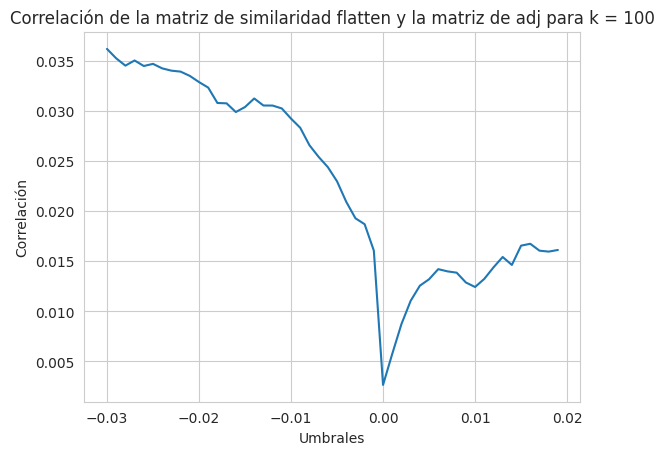

In [24]:
face_mat_adj = face.flatten()
cor_flatten_pca = []

for j in range(0, len(u)): 
    U = (mat_similaridad > u[j])
    U = U.astype(int)
    
    mat_simi_filt = U.flatten()
    cor_flatten_pca.append(np.corrcoef(mat_simi_filt,  face_mat_adj)[0,1])
    cor_flatten_pca = [abs(i) for i in cor_flatten_pca]
#print(cor_flatten_pca)
plt.title("Correlación de la matriz de similaridad flatten y la matriz de adj para k = 100")
plt.plot(u, cor_flatten_pca)
plt.xlabel("Umbrales")
plt.ylabel("Correlación")

Ahora lo generalizamos 

In [25]:
def pca(k):
    u = np.arange(-0.03, 0.02, 0.001)
    
    V_k = V[: , 0:k ]
    
    tranformados = V_k.T @ X.T
    mat_similaridad = tranformados.T @ tranformados

    face_mat_adj = face.flatten()
    cor_flatten_pca = []

    for j in range(0, len(u)): 
        U = (mat_similaridad > u[j])
        U = U.astype(int)
        
        mat_simi_filt = U.flatten()
        cor_flatten_pca.append(np.corrcoef(mat_simi_filt,  face_mat_adj)[0,1])
        cor_flatten_pca = [abs(i) for i in cor_flatten_pca]
    #print(cor_flatten_pca)
    plt.title("Correlación de la matriz de similaridad flatten y la matriz de adj para k = 100")
    plt.plot(u, cor_flatten_pca)
    plt.xlabel("Umbrales")
    plt.ylabel("Correlación")
    return cor_flatten_pca


Veamos PCA para varios k

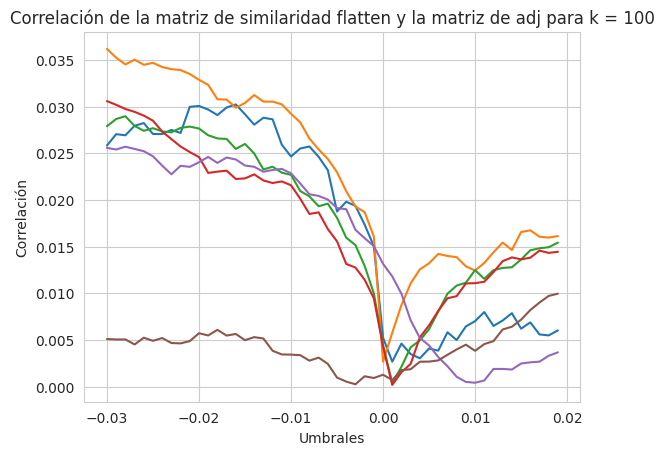

In [26]:
u = list(np.arange(-0.03, 0.02, 0.001))
cors_flatten = [pca(i) for i in range(50, 319, 50)]
k_s = list(range(50, 319, 50))


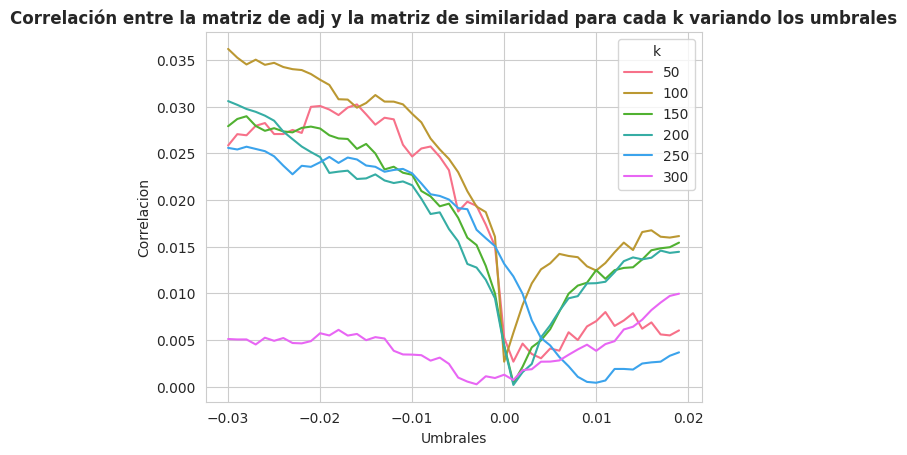

In [27]:

data = pd.DataFrame()
data["Umbrales"] = u * len(cors_flatten)
data["Correlacion"] = [item for sublist in cors_flatten for item in sublist]

s = [ len(u)*[str(k)] for k in k_s]
data["k"] = [item for sublist in s for item in sublist]

sns.lineplot(data, x ="Umbrales", y ="Correlacion", hue="k",  palette= "husl")
plt.title("Correlación entre la matriz de adj y la matriz de similaridad para cada k variando los umbrales", fontweight = "bold")
plt.show()

Ahora vamos a hacer lo mismo pero vamos a ver la similaridad con los autovalores 

In [28]:
def pca_autovals(k):
    u = np.arange(-0.03, 0.02, 0.005)
    
    V_k = V[: , 0:k ]
    
    tranformados = V_k.T @ X.T
    mat_similaridad = tranformados.T @ tranformados

    face_mat_adj = face
    eigvals_face = sorted(linalg.eigvals(face_mat_adj))
    cor_autovals_pca = []

    for j in range(0, len(u)): 
        U = (mat_similaridad > u[j])
        U = U.astype(int)
        
        eigvals_U = linalg.eigvals( U)
        eigvals_U = sorted(eigvals_U)
        
        cor_autovals_pca.append(np.corrcoef(np.real(eigvals_U), np.real(eigvals_face) )[0,1])

    #print(cor_autovals_pca)
    plt.title("Correlación de los autovalores de la matriz de adj y de la matriz de similaridad")
    plt.plot(u, cor_autovals_pca)
    plt.xlabel("Umbrales")
    plt.ylabel("Correlación")
    return cor_autovals_pca

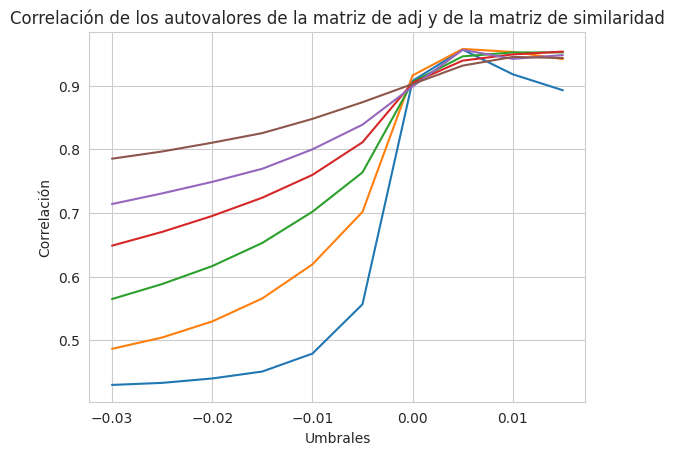

In [29]:
u = list(np.arange(-0.03, 0.02, 0.005))
cors_autovals = [pca_autovals(i) for i in range(50, 319, 50)]
k_s = list(range(50, 319, 50))

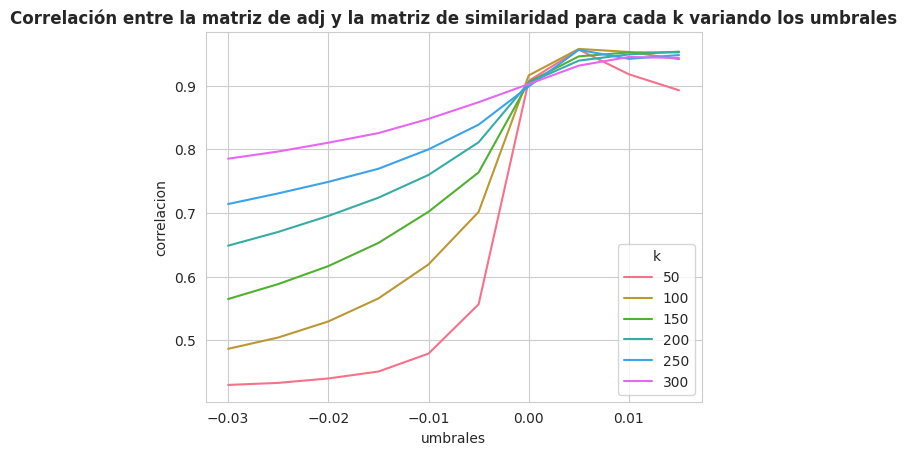

In [30]:

data = pd.DataFrame()
data["umbrales"] = u * len(cors_autovals)
data["correlacion"] = [item for sublist in cors_autovals for item in sublist]

s = [ len(u)*[str(k)] for k in k_s]
data["k"] = [item for sublist in s for item in sublist]

sns.lineplot(data, x ="umbrales", y ="correlacion", hue="k",  palette= "husl")
plt.title("Correlación entre la matriz de adj y la matriz de similaridad para cada k variando los umbrales", fontweight = "bold")
plt.show()